# Measuring the association between two variables using kernel regression

If we want to measure the association between two real variables $x$ and $y$, our first go-to method is Pearson's correlation ($R$). If we want a statistic which starts at 0 and increases for a stronger association, we use $R^2$. $R$ measures strength of linear relationship.

We also have Kendall's $\tau$ or Spearman's $\rho$, alternative correlation measures which work on ranks, so they allow for measuring the strength of non-linear but still monotonic relationships.

There is also the mutual information MI, which can measure the strength of non-linear, non-monotonic relationships. Its disadvantage is that it bins the data, because MI is defined for discrete cells. But this is conceptually bad, when dealing with real numbers. It discards the order of cells. And what if the data is split across a couple of cells, by bad luck?

This notebook proposes a novel method of measuring the association between two real variables, based on kernel regression. Kernel regression estimates the value of $y$ given a query point $x$ by taking a weighted average of the $y$ values of points near to $x$. Here "weighted average" means weighted by the value of the kernel, which measures how close each $x$ value is to the query point. We can fit $y = f(x)$ using kernel regression. If the training error in that fit is low, it shows that $x$ is useful for predicting $y$, hence there is an association. Thus we could define the kernel regression training error as a measure of independence: large errors => highly independent. 

For compatibility with other measures, we'll invert, ie take 1 / training error. Thus, large values => strong relationship.

There can also be the opposite direction association: $x = f(y)$. This is importantly different because there are functions, such as sinusoids, where one relationship is clear-cut and the other is not because of duplicate values. So we can define a possibly better measure of association by taking either the mean of the $xy$ training error and the $yx$ training error, or the max of them. (Why max? It is the *best* relationship which we are trying to measure.)

In the implementation below, we will always min-max normalise both $x$ and $y$, so that their scale doesn't affect the scale of the training errors. 

We don't need to consider test errors here, because this is about the association within a single dataset, not about generalisation in any sense. In this context, to avoid the danger that a regression method would just "memorise" each training data point and so get a zero error, we default to an RBF kernel and set the kernel bandwidth with a common rule of thumb which ensures weighting and prevents direct return of an individual $y$ value. 

We use Scikit-Learn `KernelRidge`. Kernel Ridge Regression is regularised, so again this prevents memorisation.

There is also another baseline method which I hadn't previously heard of, the Hilbert-Schmidt Independence Criterion (HSIC). For information, see:

* https://raw.githubusercontent.com/Black-Swan-ICL/PyRKHSstats
* https://jejjohnson.github.io/research_journal/appendix/similarity/hsic/, mentions HSIC is computationally intensive

But for now, we test all of the above methods on a set of easy-to-understand test cases. We'll see that the Kernel Regression Association works well!

# Implementing our measure of association

In [1]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kendalltau
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from PyRKHSstats.kernel_wrapper import KernelWrapper # pip install PyRKHSstats
from PyRKHSstats import hsic

In [2]:
def KRA(x, y, mode='mean', kernel='rbf', bandwidth=None):
    '''
    Kernel Regression Association (KRA): the method proposed in this notebook.

    Calculates a value indicating the strength of association between real vectors x and y.

    The mode can be:
    mean: take the mean of the x-y and the y-x relationship
    max: take the max (ie the better) of the x-y and the y-x relationship
    xy: take the xy relationship only
    yx: take the yx relationship only

    The kernel and bandwidth can take typical values as accepted by Scikit-Learn KernelRidge.

    Return: a float. Higher indicates a stronger association.
    '''
    
    # Min-max normalize x and y
    x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1))
    y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1))
    
    # Estimate bandwidth using Silverman's rule if not provided
    if bandwidth is None:
        n = len(x)
        std_dev = np.std(x_scaled, ddof=1)
        bandwidth = 1.06 * std_dev * n ** (-1/5)
    
    # Set up the kernel ridge models
    if kernel == 'rbf':
        gamma = 1 / (2 * bandwidth ** 2)
        if mode != 'yx':
            model_xy = KernelRidge(kernel=kernel, alpha=1.0, gamma=gamma)
        if mode != 'xy':
            model_yx = KernelRidge(kernel=kernel, alpha=1.0, gamma=gamma)
    else:
        if mode != 'yx':
            model_xy = KernelRidge(kernel=kernel, alpha=1.0)
        if mode != 'xy':
            model_yx = KernelRidge(kernel=kernel, alpha=1.0)
    
    # Fit the models, predict, and calculate errors
    # Only do the xy model if needed, and same for yx
    if mode != 'yx': 
        model_xy.fit(x_scaled, y_scaled)
        y_pred = model_xy.predict(x_scaled)
        error_xy = mean_squared_error(y_scaled, y_pred)
        assoc_xy = 1 / error_xy
    if mode != 'xy':
        model_yx.fit(y_scaled, x_scaled)
        x_pred = model_yx.predict(y_scaled)
        error_yx = mean_squared_error(x_scaled, x_pred)
        assoc_yx = 1 / error_yx
        
    # Return the average of the association values
    if mode == 'mean':
        return (assoc_xy + assoc_yx) / 2
    elif mode == 'max':
        return max(assoc_xy, assoc_yx)
    elif mode == 'xy':
        return assoc_xy
    elif mode == 'yx':
        return assoc_yx
    else:
        raise ValueError(f'Unknown mode {mode}')

# Implementing baselines

In [3]:
def calculate_mutual_information(x, y, nbins=10):
    # Create a discretizer object with specified number of bins and uniform strategy
    discretizer = KBinsDiscretizer(n_bins=nbins, encode='ordinal', strategy='uniform')
    
    # Fit and transform the data
    x_binned = discretizer.fit_transform(x.reshape(-1, 1)).reshape(-1)
    y_binned = discretizer.fit_transform(y.reshape(-1, 1)).reshape(-1)
    
    # Calculate mutual information
    mi = mutual_info_score(x_binned, y_binned)
    
    return mi

In [4]:
def calculate_pearson_r_squared(x, y):
    correlation = np.corrcoef(x, y)[0, 1]
    r_squared = correlation**2
    return r_squared

In [5]:
def calculate_kendall_tau_squared(x, y):
    tau, _ = kendalltau(x, y)
    tau_squared = tau**2
    return tau_squared

In [6]:
def calculate_hsic(x, y, sigma=None):
    """
    Compute the HSIC statistic between two datasets x and y using RBF kernels.
    Implements Silverman's rule of thumb to estimate the bandwidth if not provided.

    Parameters:
    - x (np.ndarray): Input data in the X domain.
    - y (np.ndarray): Input data in the Y domain.
    - sigma (float): Optional bandwidth for the RBF kernel. If None, Silverman's rule is used.

    Returns:
    - float: The HSIC statistic as a float.
    """
    # Ensure input is numpy array and reshape if necessary
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)

    # Apply Silverman's rule of thumb to estimate bandwidth if not provided
    if sigma is None:
        pooled_data = np.vstack([x, y])
        std_dev = np.std(pooled_data, ddof=1)
        n = pooled_data.shape[0]
        sigma = 1.06 * std_dev * n ** (-1/5)

    # Define the RBF kernel with the calculated or provided sigma for both X and Y domains
    length_scale = np.sqrt(sigma / 2)
    kernel_x = KernelWrapper(RBF(length_scale=length_scale))
    kernel_y = KernelWrapper(RBF(length_scale=length_scale))

    # Compute biased HSIC using the provided utilities
    results = hsic.compute_biased_hsic(x, y, kernel_x, kernel_y)
    
    return results['HSIC']

# Creating test cases

In [7]:
# Load Anscombe's quartet
anscombe = sns.load_dataset('anscombe')

# add the dataset
anscombe_cases = {}
for i in 'I', 'II', 'III', 'IV':
    df = anscombe[anscombe['dataset'] == i]
    x = df['x'].values
    y = df['y'].values
    anscombe_cases[i] = (x, y)

In [8]:
# Generate further test cases
# and put them all in order of strength of association, strongest to weakest (subjective, of course)

np.random.seed(42)
x = np.random.rand(100)
test_cases = {
    'Linear': (x, 0.5 * x + 0.1),
    'Square root': (x, np.sqrt(x)),
    'Inverse': (x + 0.5, 1 / (x+0.5)),
    'Logarithmic': (x + 0.1, np.log(x + 0.1)),
    'Circular': (x, np.sqrt(1 - (2 * x - 1)**2)),
    'Non-monotonic polynomial (degree 5)': (x, 0.1 * (x - 0.2) * (x / 4 - 0.4) * (x - 0.6) * (x - 0.8)),
    'Step function': (x, np.floor(2 * x)),
    'Sinusoidal': (x, np.sin(2 * np.pi * x)),
    'Faster sinusoidal': (x, np.sin(3 * 2 * np.pi * x)),
    'Sawtooth': (x, (x * 4) % 1),
    'Anscombe II': anscombe_cases['II'],
    'Anscombe III': anscombe_cases['III'],
    'Anscombe IV': anscombe_cases['IV'],
    'Noisy linear': (x, 0.5 * x + np.random.normal(size=100) * 0.1),
    'Anscombe I': anscombe_cases['I'],
    'No association': (x, np.random.rand(100)),
}

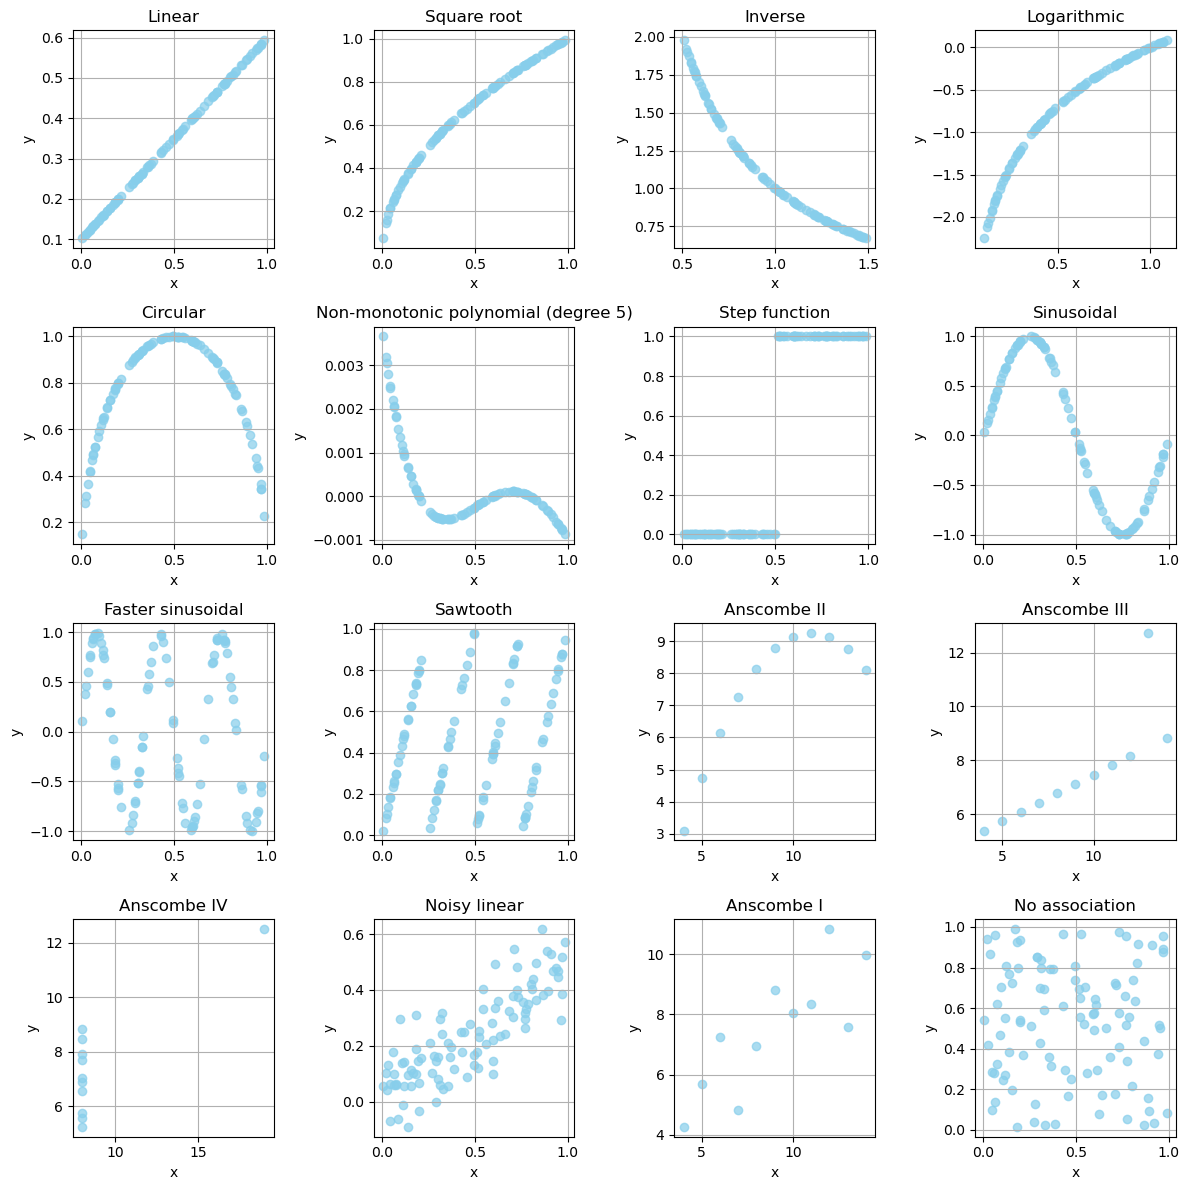

In [9]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

# Generate plots for each test case
for ax, (title, (x, y)) in zip(axes, test_cases.items()):
    ax.scatter(x, y, facecolor='skyblue', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Experiments and results

In [16]:
results = []

# Evaluate all test cases
for case_name, (x, y) in test_cases.items():
    case_results = {
        'Test Case': case_name,
        'Kernel Regression Association (mode=mean)': KRA(x, y),
        'Kernel Regression Association (mode=max)': KRA(x, y, mode='max'),
        'Mutual Information': calculate_mutual_information(x, y),
        'HSIC': calculate_hsic(x, y),
        'Pearson R^2': calculate_pearson_r_squared(x, y),
        'Kendall Tau^2': calculate_kendall_tau_squared(x, y)
    }
    results.append(case_results)

# Convert list to DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

,Test Case,Kernel Regression Association (mode=mean),Kernel Regression Association (mode=max),Mutual Information,HSIC,Pearson R^2,Kendall Tau^2
0,Linear,863.845486,961.271475,2.264703,0.084497,1.000000,1.000000
1,Square root,577.845666,1104.991609,1.753300,0.110577,0.963831,1.000000
2,Inverse,355.504154,979.329060,1.602162,0.113796,0.929957,1.000000
3,Logarithmic,423.034827,1032.398672,1.615500,0.083059,0.929242,1.000000
4,Circular,93.433295,709.694424,1.276576,0.036533,0.010449,0.013729
5,Non-monotonic polynomial (degree 5),43.387168,577.805774,1.065294,0.000002,0.379941,0.147022
6,Step function,36.634460,68.447992,0.691346,0.135121,0.770336,0.503232
7,Sinusoidal,38.901847,1224.411651,1.424429,0.076692,0.615059,0.203684
8,Faster sinusoidal,10.770647,59.375283,0.857744,0.006282,0.081567,0.045339
9,Sawtooth,12.375182,22.062179,0.942229,0.005082,0.070906,0.066449


# Summarising results

The results are a bit hard to interpret, so let's summarise. The idea is: which method of association correctly ranks the test cases?

Our test cases are in a **subjective** ordering of the strength and obviousness of the relationships, from strongest to weakest. It's hard to see how to do this other than with a subjective ordering. There's no correct ordering here, since if there was we would just use that, instead of inventing new methods. 

Anyway, given this subjective "correct" ordering, we can just measure how much each method agrees with it. We can use Kendall's $\tau$ (not $\tau^2$) for this. (Don't get confused between this use of $\tau$ to measure the agreement in rankings, and the original use of $\tau$ as a measure of association between $x$ and $y$.)

Because our subjective ordering is from strongest to weakest, and the measures of association give high values to strong relationships, we reverse the order in the code below.

In [14]:
# Calculate Kendall's tau for each method
kendalls_tau = {}
for method in results_df.columns[1:]:  # Skip the 'Test Case' column
    # calculate the agreement, NB reverse order here
    tau, p_value = kendalltau(list(range(len(results) -1, -1, -1)), results_df[method])
    kendalls_tau[method] = tau

# Print Kendall's tau results
for method, tau in kendalls_tau.items():
    print(f"Kendall's tau for {method}: {tau:.3f}")

Kendall's tau for Kernel Regression Association (mode=mean): 0.717
Kendall's tau for Kernel Regression Association (mode=max): 0.650
Kendall's tau for Mutual Information: 0.417
Kendall's tau for HSIC: 0.367
Kendall's tau for Pearson R^2: 0.333
Kendall's tau for Kendall Tau^2: 0.308


## It looks like the Kernel Regression method wins! By a lot!

# Discussion and TODO

* Which cases are the most contentious among the methods?
* Which are the cases which the Kernel Regression method does "well" on, versus other methods?
* Do you agree with the subjective ordering?
* Kernel Ridge Regression is regularised. Should we try pure kernel regression?
* The links above re HSIC also have tests which could be useful to us.